In [1]:
import numpy as np
import matplotlib.pyplot as plt

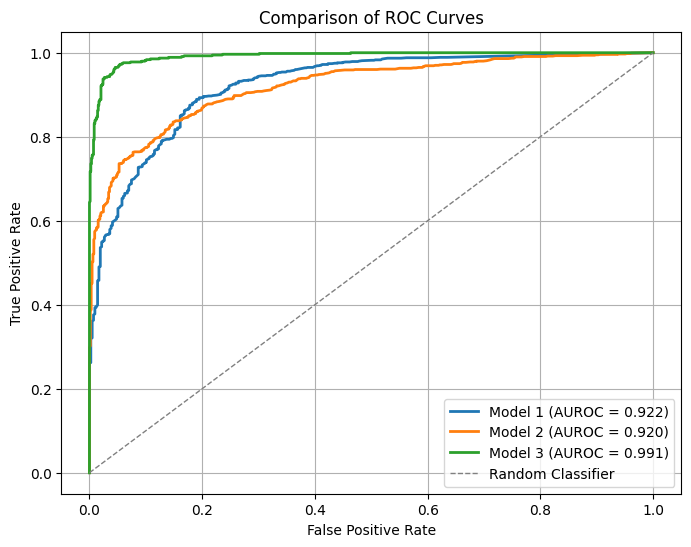

In [7]:


fpr1, tpr1 = np.load("../output/BraTS/model/args_brats_22/fpr.npy"), np.load("../output/BraTS/model/args_brats_22/tpr.npy")
fpr2, tpr2 = np.load("../output/LiTS/model/args_lits_14/fpr.npy"), np.load("../output/LiTS/model/args_lits_14/tpr.npy")
fpr3, tpr3 = np.load("../output/Ultrasound/model/args_us_45/fpr.npy"), np.load("../output/Ultrasound/model/args_us_45/tpr.npy")

# AUROC values (Replace these with actual values)
auroc1, auroc2, auroc3 = 0.922, 0.920, 0.991  # Example AUROC values

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, label=f'Model 1 (AUROC = {auroc1:.3f})', linewidth=2)
plt.plot(fpr2, tpr2, label=f'Model 2 (AUROC = {auroc2:.3f})', linewidth=2)
plt.plot(fpr3, tpr3, label=f'Model 3 (AUROC = {auroc3:.3f})', linewidth=2)

# Random classifier (diagonal line)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier", linewidth=1)

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparison of ROC Curves")
plt.legend()
plt.grid()
plt.savefig(f'/home/camp/Projects/Yuan/thesis_diffusion-main/paper_images/auroc_curve.svg', format="svg")
# Show the plot
plt.show()

In [3]:
import sys

import numpy as np
import torch
from matplotlib import pyplot as plt
import cv2
import time
import itertools
from scipy.ndimage import label
import warnings
from sklearn.metrics import precision_recall_curve, auc

from helpers import *
from gaussian_diffusion import GaussianDiffusionModel, get_beta_schedule
from unet import UNetModel
import data_loader

torch.cuda.empty_cache()

def write_log_file(file_path,txt):
    with open(file_path, 'a') as f:
        f.write(txt + '\n')

def anomaly_detection(json_file_name, model_path, inference_noise_steps_list, gaussian_blur_kernel_size_list,
                      anomaly_threshold_list, diff_threshold_list=None, server='None', mode="anomalous", num_test_img=100, plot_img=False, device='cuda'):
    """
    Perform anomaly detection on the test dataset.

    :param json_file_name: JSON file name
    :param model_path: model path
    :param inference_noise_steps_list: list of inference noise steps
    :param gaussian_blur_kernel_size_list: list of gaussian blur kernel sizes
    :param anomaly_threshold_list: list of anomaly thresholds
    :param server: server name
    :param mode: test mode, "anomalous" or "healthy"
    :param num_test_img: number of test images
    :param plot_img: boolean to plot images
    :return: anomaly detection results and evaluation scores
    """

    # Load the model and its parameters
    print(f"Testing on model {json_file_name}/{model_path}")
    args = get_args_from_json(json_file_name, server=server)
    args['mode'] = mode
    args['num_test_img'] = num_test_img

    model = UNetModel(
                args['img_size'], in_channels=args['in_channels'], model_channels=args['model_channels'],
                num_res_blocks=args['num_res_blocks'], attention_resolutions=args['attention_resolutions'],
                dropout=args["dropout"], channel_mult=args['channel_mult'], num_heads=args["num_heads"],
                num_head_channels=args["num_head_channels"],
            )

    betas = get_beta_schedule(args['beta_schedule'], args['noise_steps'])

    diffusion = GaussianDiffusionModel(
            args['img_size'], betas, img_channels=args['in_channels'], loss_type=args['loss-type'],
            loss_weight=args['loss_weight'], noise_fn=args["noise_fn"], noise_params=args["noise_params"], diffusion_mode="inference"
            )

    model_params = torch.load(f'{args["output_path"]}/model/{args["json_file_name"]}/{model_path}')

    print(model_params["n_epoch"])

    model.load_state_dict(model_params["model_state_dict"])
    model.to(device)
    model.eval()

    # Load the test data and groundtruth anomaly masks
    test_dataset_loader, groundtruth_anomaly_masks = data_loader.get_test_data(args)

    # show examples of anomalous images
    # plt.figure(figsize=(25, 5))
    # for i, image in enumerate(test_dataset_loader):
    #     plt.subplot(1, 5, i+1)
    #     plt.imshow(image.cpu().detach().numpy().squeeze(), cmap="gray")
    #     plt.axis("off")
    # plt.tight_layout()
    # plt.show()
    if diff_threshold_list is not None:
        # Best combination of parameters for anomaly detection
        combination_scores = []
        parameters_ranges = [inference_noise_steps_list, gaussian_blur_kernel_size_list, anomaly_threshold_list, diff_threshold_list]
        print(f"Testing on inference noise steps: {inference_noise_steps_list} gaussian blur kernel sizes: {gaussian_blur_kernel_size_list} anomaly thresholds: {anomaly_threshold_list}"
              f"difference thresholds: {diff_threshold_list}")

        # Test on all combinations of parameters
        for combination in itertools.product(*parameters_ranges):
            inference_noise_steps = combination[0]
            gaussian_blur_kernel_size = combination[1]
            anomaly_threshold = combination[2]
            diff_threshold = combination[3]
            print(f"{args['noise_fn']} Noise steps: {inference_noise_steps}, kernel size: {gaussian_blur_kernel_size}, threshold: {anomaly_threshold}, diff threshold: {diff_threshold}")
            write_log_file(f'{args["output_path"]}/model/{args["json_file_name"]}/log'+args['mode']+'.txt',
                           f"{args['noise_fn']} Noise steps: {inference_noise_steps}, kernel size: {gaussian_blur_kernel_size}, threshold: {anomaly_threshold}, diff threshold: {diff_threshold}")

            # Run inference on the test dataset with the given parameters
            evaluation_mean, evaluation_std, anomaly_score_list, image_level_label  = run_inference(args, test_dataset_loader, model, diffusion,
                                                            groundtruth_anomaly_masks, inference_noise_steps, gaussian_blur_kernel_size, anomaly_threshold, mode, plot_img=plot_img,diff_threshold=diff_threshold)

            # Store the evaluation scores
            combination_scores.append((combination, evaluation_mean, evaluation_std))
    else:
        # Best combination of parameters for anomaly detection
        combination_scores = []
        parameters_ranges = [inference_noise_steps_list, gaussian_blur_kernel_size_list, anomaly_threshold_list]
        print(
            f"Testing on inference noise steps: {inference_noise_steps_list} gaussian blur kernel sizes: {gaussian_blur_kernel_size_list} anomaly thresholds: {anomaly_threshold_list}")

        # Test on all combinations of parameters
        for combination in itertools.product(*parameters_ranges):
            inference_noise_steps = combination[0]
            gaussian_blur_kernel_size = combination[1]
            anomaly_threshold = combination[2]
            print(f"{args['noise_fn']} Noise steps: {inference_noise_steps}, kernel size: {gaussian_blur_kernel_size}, threshold: {anomaly_threshold}")
            write_log_file(f'{args["output_path"]}/model/{args["json_file_name"]}/log'+args['mode']+'.txt',
                           f"{args['noise_fn']} Noise steps: {inference_noise_steps}, kernel size: {gaussian_blur_kernel_size}, threshold: {anomaly_threshold}")

            # Run inference on the test dataset with the given parameters
            evaluation_mean, evaluation_std, anomaly_score_list, image_level_label = run_inference(args, test_dataset_loader, model, diffusion,
                                                            groundtruth_anomaly_masks, inference_noise_steps,
                                                            gaussian_blur_kernel_size, anomaly_threshold, mode,
                                                            plot_img=plot_img)

            # Store the evaluation scores
            combination_scores.append((combination, evaluation_mean, evaluation_std))

    # Print the best combinations and their evaluation scores
    if mode == "healthy":
        sorted_ssim_scores = sorted(combination_scores, key=lambda x: x[1]['ssim_score'], reverse=True)
        print(f"{args['noise_fn']} Best combinations:")
        for i, (combination, evaluation_mean, evaluation_std) in enumerate(sorted_ssim_scores[:20], 1):
            print(f"#{i} Combination: {combination}, SSIM score: {evaluation_mean['ssim_score']}+-{evaluation_std['ssim_score']}")
    elif mode == "anomalous" or mode == "both":
        sorted_dice_scores = sorted(combination_scores, key=lambda x: x[1]['dice_score'], reverse=True)
        print(f"{args['noise_fn']} Best combinations:")
        write_log_file(f'{args["output_path"]}/model/{args["json_file_name"]}/log'+args['mode']+'.txt',f"{args['noise_fn']} Best combinations:")

        for i, (combination, evaluation_mean, evaluation_std) in enumerate(sorted_dice_scores[:20], 1):
            print(f"#{i} Combination: {combination} Dice score: {evaluation_mean['dice_score']}+-{evaluation_std['dice_score']}, AUPRC score: {evaluation_mean['auprc_score']}+-{evaluation_std['auprc_score']}, IoU score: {evaluation_mean['iou_score']}+-{evaluation_std['iou_score']}, Hausdorff score: {evaluation_mean['hausdorff_score']}+-{evaluation_std['hausdorff_score']}")
            write_log_file(f'{args["output_path"]}/model/{args["json_file_name"]}/log'+args['mode']+'.txt',f"#{i} Combination: {combination} Dice score: {evaluation_mean['dice_score']}+-{evaluation_std['dice_score']}, AUPRC score: {evaluation_mean['auprc_score']}+-{evaluation_std['auprc_score']}, IoU score: {evaluation_mean['iou_score']}+-{evaluation_std['iou_score']}, Hausdorff score: {evaluation_mean['hausdorff_score']}+-{evaluation_std['hausdorff_score']}")
    else:
        raise ValueError("Unsupported mode")
        
    return evaluation_mean, evaluation_std, anomaly_score_list, image_level_label


def run_inference(args, test_dataset_loader, model, diffusion, groundtruth_anomaly_masks, inference_noise_steps, gaussian_blur_kernel_size, anomaly_threshold, mode, plot_img=False, device='cuda', diff_threshold=100):
    """
    Run inference on the test dataset with the given parameters. Calculate the evaluation scores.

    :param test_dataset_loader: test dataset loader
    :param model: model state
    :param diffusion: diffusion model
    :param groundtruth_anomaly_masks: groundtruth anomaly masks
    :param inference_noise_steps: inference noise steps
    :param gaussian_blur_kernel_size: gaussian blur kernel size
    :param anomaly_threshold: anomaly threshold
    :param mode: test mode, "anomalous" or "healthy"
    :param plot_img: boolean to plot images
    :return: mean and standard deviation of evaluation scores for the given parameters
    """

    evaluation_score_list = []
    anomaly_score_list = []
    iter_nums = []

    start_time_combination = time.time()
    for i, image in enumerate(test_dataset_loader):
        # print(f"Predicting image {i + 1} of {len(test_dataset_loader)}")
        inference_images = []

        x_0 = image.to(device)
        if plot_img:
            inference_images.append(x_0)
        x_pred, x_t = None, None


        with torch.no_grad():
            # Single-stage inference
            if isinstance(inference_noise_steps, int):
                t = torch.tensor([inference_noise_steps], device=x_0.device).repeat(x_0.shape[0])
                noise = diffusion.noise_fn(x_0, None)
                x_t = diffusion.q_sample(x_0, t, noise)
                x_pred = diffusion.p_sample(model, x_t, t)

                if plot_img:
                    inference_images.extend([x_t, x_pred])

            # Multi-stage inference
            elif isinstance(inference_noise_steps, list) and len(inference_noise_steps) > 1:
                x_0_cache = x_0

                for j, inference_noise_step in enumerate(inference_noise_steps):
                    t = torch.tensor([inference_noise_step], device=x_0_cache.device).repeat(x_0_cache.shape[0])
                    noise = diffusion.noise_fn(x_0_cache, None)
                    x_t = diffusion.q_sample(x_0_cache, t, noise)
                    x_pred = diffusion.p_sample(model, x_t, t)
                    x_0_cache = x_pred

                    if plot_img:
                        inference_images.extend([x_t, x_pred])

                del x_0_cache

            else:
                x_0_cache = x_0
                difference_map_cache = np.ones_like(x_0.cpu().squeeze().numpy())
                iter_num = 0
                difference = 255*255

                while difference > diff_threshold:
                    t = torch.tensor([inference_noise_steps[0]], device=x_0_cache.device).repeat(x_0_cache.shape[0])
                    noise = diffusion.noise_fn(x_0_cache, None)
                    x_t = diffusion.q_sample(x_0_cache, t, noise)
                    x_pred = diffusion.p_sample(model, x_t, t)
                    # difference_map = create_gaussian_blur_difference_map(x_0, x_pred, kernel_size=gaussian_blur_kernel_size,
                    #                                                      threshold=anomaly_threshold)
                    difference_map = create_gaussian_blur_difference_map(x_0, x_pred,
                                                                         kernel_size=3,
                                                                         threshold=0.1)
                    # difference_map_s = create_gaussian_blur_difference_map(x_0, x_pred, kernel_size=gaussian_blur_kernel_size,
                    #                                                      threshold=anomaly_threshold)
                    x_0_cache=x_pred
                    difference_map = difference_map.astype(bool).astype(int)

                    # difference_map_t = torch.from_numpy(difference_map)
                    # difference_map_t = difference_map_t.view(1,1,128,128).to(device)
                    # x_0_cache = x_pred*difference_map_t+x_0*(1-difference_map_t)

                    # difference_map_s_t = torch.from_numpy(difference_map_s)
                    # difference_map_s_t = difference_map_s_t.view(1, 1, 128, 128).to(device)

                    # if plot_img:
                    #     inference_images.extend([x_t, x_pred])


                    if plot_img:
                        inference_images.extend([x_t, x_pred,difference_map_s_t,x_0_cache])


                    nominator = np.abs(np.sum(difference_map_cache.astype(bool).astype(int))-np.sum(difference_map.astype(bool).astype(int)))
                    denominator = np.max([np.sum(difference_map_cache.astype(bool).astype(int)),500])
                    difference = nominator/denominator
                    difference_map_cache = difference_map
                    iter_num += 1
                    if iter_num>=5:
                        break

                del x_0_cache, difference_map_cache
                iter_nums.append(iter_num)
                # print(iter_num)
        # Create predicted difference map
        difference_map = create_gaussian_blur_difference_map(x_0, x_pred, kernel_size=gaussian_blur_kernel_size, threshold=anomaly_threshold)

        # Calculate evaluation scores based on ground truth and predicted anomaly
        groundtruth_anomaly_mask = groundtruth_anomaly_masks[i]
        groundtruth_anomaly = groundtruth_anomaly_mask.astype(bool)
        predicted_anomaly = difference_map.astype(bool)

        # anomaly_score = np.sum(predicted_anomaly)
        anomaly_score = get_ssim_score(x_0, x_pred)

        evaluation_scores = {
            "dice_score": get_dice_score(groundtruth_anomaly, predicted_anomaly),
            "auprc_score": get_auprc_score(groundtruth_anomaly, difference_map),
            "iou_score": get_iou_score(groundtruth_anomaly, predicted_anomaly),
            "precision_score": get_precision_score(groundtruth_anomaly, predicted_anomaly),
            "recall_score": get_recall_score(groundtruth_anomaly, predicted_anomaly),
            "fpr_score": get_fpr_score(groundtruth_anomaly, predicted_anomaly),
            "hausdorff_score": get_hausdorff_distance(groundtruth_anomaly, predicted_anomaly),
            # "ssim_score": get_ssim_score(x_0, x_pred)
        }

        # print(f"Dice score: {dice_score}, IOU score: {iou_score}, Precision: {precision_score}, Recall: {recall_score}, FPR: {fpr_score}")
        evaluation_score_list.append(evaluation_scores)
        anomaly_score_list.append(anomaly_score.item())

        if plot_img:
            plot_detected_anomaly(inference_images, difference_map, groundtruth_anomaly_mask, inference_noise_steps, gaussian_blur_kernel_size, anomaly_threshold, evaluation_scores)

        del x_0, x_t, x_pred

    score_names = list(evaluation_score_list[0].keys())
    evaluation_mean = {score_name: round(np.mean([entry[score_name] for entry in evaluation_score_list]), 4) for score_name in score_names}
    evaluation_std = {score_name: round(np.std([entry[score_name] for entry in evaluation_score_list]), 4) for score_name in score_names}

    image_level_label = [(1 if np.sum(img) > 1 else 0) for img in groundtruth_anomaly_masks]

    image_level_label = np.array(image_level_label)
    anomaly_score_list = 1-np.array(anomaly_score_list)
    precision, recall, _ = precision_recall_curve(image_level_label, anomaly_score_list)
    auprc = auc(recall, precision)

    if len(iter_nums)==0:
        iter_nums.append(0)
    print("Average iter num: ", np.mean(iter_nums))

    if mode == "healthy":
        print(f"Average SSIM score: {evaluation_mean['ssim_score']}+-{evaluation_std['ssim_score']}")
    else:
        # print(f"Average DICE score: {evaluation_mean['dice_score']}+-{evaluation_std['dice_score']}, average AUPRC score: {evaluation_mean['auprc_score']}+-{evaluation_std['auprc_score']}, average IOU score: {evaluation_mean['iou_score']}+-{evaluation_std['iou_score']}, average Precision: {evaluation_mean['precision_score']}+-{evaluation_std['precision_score']}, average Recall: {evaluation_mean['recall_score']}+-{evaluation_std['recall_score']}, average FPR: {evaluation_mean['fpr_score']}+-{evaluation_std['fpr_score']}, average Hausdorff: {evaluation_mean['hausdorff_score']}+-{evaluation_std['hausdorff_score']}, average SSIM: {evaluation_mean['ssim_score']}+-{evaluation_std['ssim_score']}")
        print(f"Average DICE score: {evaluation_mean['dice_score']}+-{evaluation_std['dice_score']}, AUPRC score: {auprc}, average IOU score: {evaluation_mean['iou_score']}+-{evaluation_std['iou_score']}, average Precision: {evaluation_mean['precision_score']}+-{evaluation_std['precision_score']}, average Recall: {evaluation_mean['recall_score']}+-{evaluation_std['recall_score']}, average FPR: {evaluation_mean['fpr_score']}+-{evaluation_std['fpr_score']}, average Hausdorff: {evaluation_mean['hausdorff_score']}+-{evaluation_std['hausdorff_score']}, average SSIM: {evaluation_mean['ssim_score']}+-{evaluation_std['ssim_score']}")
        # write_log_file(f'{args["output_path"]}/model/{args["json_file_name"]}/log'+args['mode']+'.txt',f"Average DICE score: {evaluation_mean['dice_score']}+-{evaluation_std['dice_score']}, average AUPRC score: {evaluation_mean['auprc_score']}+-{evaluation_std['auprc_score']}, average IOU score: {evaluation_mean['iou_score']}+-{evaluation_std['iou_score']}, average Precision: {evaluation_mean['precision_score']}+-{evaluation_std['precision_score']}, average Recall: {evaluation_mean['recall_score']}+-{evaluation_std['recall_score']}, average FPR: {evaluation_mean['fpr_score']}+-{evaluation_std['fpr_score']}, average Hausdorff: {evaluation_mean['hausdorff_score']}+-{evaluation_std['hausdorff_score']}, average SSIM: {evaluation_mean['ssim_score']}+-{evaluation_std['ssim_score']}")
        write_log_file(f'{args["output_path"]}/model/{args["json_file_name"]}/log'+args['mode']+'.txt',f"Average DICE score: {evaluation_mean['dice_score']}+-{evaluation_std['dice_score']}, AUPRC score: {auprc}, average IOU score: {evaluation_mean['iou_score']}+-{evaluation_std['iou_score']}, average Precision: {evaluation_mean['precision_score']}+-{evaluation_std['precision_score']}, average Recall: {evaluation_mean['recall_score']}+-{evaluation_std['recall_score']}, average FPR: {evaluation_mean['fpr_score']}+-{evaluation_std['fpr_score']}, average Hausdorff: {evaluation_mean['hausdorff_score']}+-{evaluation_std['hausdorff_score']}, average SSIM: {evaluation_mean['ssim_score']}+-{evaluation_std['ssim_score']}")
    print(f"Time taken: {time.time() - start_time_combination:02.0f} seconds")

    return evaluation_mean, evaluation_std, anomaly_score_list, image_level_label


def create_gaussian_blur_difference_map(x_0, x_pred, kernel_size=3, threshold=5.0):
    """
    Create a difference map between the input image and the predicted input image with Gaussian blur.

    :param x_0: input image
    :param x_pred: predicted input image
    :param kernel_size: kernel size for Gaussian blur
    :param threshold: threshold for anomaly
    :return: difference map
    """

    x_0_array = x_0.cpu().squeeze().numpy()
    x_0_blurred = cv2.GaussianBlur(x_0_array, (kernel_size, kernel_size), 0)
    x_pred_array = x_pred.cpu().detach().numpy().squeeze()
    x_pred_blurred = cv2.GaussianBlur(x_pred_array, (kernel_size, kernel_size), 0)

    diff = abs(x_0_blurred - x_pred_blurred)
    diff[diff < threshold] = 0

    diff_final = remove_small_spots(diff)
    return diff_final


def remove_small_spots(map, threshold=30):
    """
    Remove too small spots from the difference map.

    :param map: difference map
    :param threshold: threshold for the size of the spots
    :return: difference map with removed small spots
    """

    binary_map = map > 0
    labeled_map, num_features = label(binary_map)
    component_sizes = np.bincount(labeled_map.ravel())
    large_components_masked = component_sizes[labeled_map] >= threshold
    return large_components_masked * map


def plot_detected_anomaly(inference_images, predicted_anomaly_map, groundtruth_anomaly_mask, inference_noise_steps, gaussian_blur_kernel_size, anomaly_threshold, evaluation_scores):
    """
    Plot the input image, predicted input image, detected anomaly and ground truth anomaly. For multi-stage inference, plot the different inference stages.

    :param inference_images: inference images
    :param predicted_anomaly_map: predicted anomaly map
    :param groundtruth_anomaly_mask: ground truth anomaly mask
    :param inference_noise_steps: inference noise steps
    :param gaussian_blur_kernel_size: kernel size for Gaussian blur
    :param anomaly_threshold: threshold for anomaly
    :param evaluation_scores: evaluation scores
    :return: plot of the images and evaluation scores
    """

    font_size = 24

    # Multi-stage inference
    if len(inference_images) > 3:
        # plot multiple stages
        fig, axs = plt.subplots(1, len(inference_images), figsize=(len(inference_images) * 4 + 2, 6))
        for i, image in enumerate(inference_images):
            axs[i].imshow(image.cpu().detach().numpy().squeeze(), cmap="gray")
            # axs[i].set_title(f"Stage {i // 2}" if i % 2 == 0 else f"Stage {i // 2} noised", fontsize=30)
        plt.suptitle(f"Different stages with {len(inference_noise_steps)} noise stages", fontsize=30)
        # plt.suptitle(f"Different stages with 1 noise stage", fontsize=30)
        plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
        plt.tight_layout()
        plt.show()

        # plot the final result
        fig, axs = plt.subplots(1, 4, figsize=(18, 6))
        axs[0].imshow(inference_images[0].cpu().detach().numpy().squeeze(), cmap="gray")
        # axs[0].set_title("Input image", fontsize=font_size)
        axs[1].imshow(inference_images[-3].cpu().detach().numpy().squeeze(), cmap="gray")
        # axs[1].set_title("Predicted input image", fontsize=font_size)
        axs[2].imshow(predicted_anomaly_map)
        # axs[2].set_title(f"Detected anomaly", fontsize=font_size)
        axs[3].imshow(groundtruth_anomaly_mask.astype(bool))
        # axs[3].set_title("True anomaly", fontsize=font_size)

    # Single-stage inference
    else:
        x_0, x_t, x_pred = inference_images
        x_0 = x_0.cpu().detach().numpy().squeeze()
        x_t = x_t.cpu().detach().numpy().squeeze()
        x_pred = x_pred.cpu().detach().numpy().squeeze()

        fig, axs = plt.subplots(1, 5, figsize=(22, 6))
        axs[0].imshow(x_0, cmap="gray")
        axs[0].set_title("Input image", fontsize=font_size)
        axs[1].imshow(x_t, cmap="gray")
        axs[1].set_title("Noised image", fontsize=font_size)
        axs[2].imshow(x_pred, cmap="gray")
        axs[2].set_title("Predicted input image", fontsize=font_size)
        axs[3].imshow(predicted_anomaly_map)
        axs[3].set_title(f"Detected anomaly", fontsize=font_size)
        axs[4].imshow(groundtruth_anomaly_mask.astype(bool))
        axs[4].set_title("True anomaly", fontsize=font_size)

    # plt.suptitle(f"{inference_noise_steps} noise steps, kernel size {gaussian_blur_kernel_size}, threshold {anomaly_threshold}, \n Dice score: {evaluation_scores[0]}, IOU score: {evaluation_scores[1]}, Precision: {evaluation_scores[2]}, Recall: {evaluation_scores[3]}, FPR: {evaluation_scores[4]}")
    if healthy_or_anomalous_mode == "healthy":
        plt.suptitle(f"{inference_noise_steps} noise steps, kernel size {gaussian_blur_kernel_size}, threshold {anomaly_threshold}, \n SSIM score: {evaluation_scores['ssim_score']}")
    else:
        plt.suptitle(f"Dice score: {format(evaluation_scores['dice_score'], '.4f')}", fontsize=font_size)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    plt.tight_layout()
    plt.show()
    plt.close('all')

    # x_0, x_t, x_pred = inference_images
    #
    # plt.figure(figsize=(6, 3))
    # plt.subplot(1, 2, 1)
    # plt.imshow(x_0.cpu().detach().numpy().squeeze(), cmap="gray")
    # plt.title("Input image")
    # plt.subplot(1, 2, 2)
    # plt.imshow(groundtruth_mask.astype(bool), cmap="gray")
    # plt.title("Anomaly")
    # plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    # plt.tight_layout()
    # plt.show()


def get_dice_score(diff_truth, diff_pred):
    """
    Calculate the Dice score between the ground truth and predicted anomaly.

    :param diff_truth: ground truth anomaly
    :param diff_pred: predicted anomaly
    :return: Dice score
    """

    if diff_truth.sum() == 0 and diff_pred.sum() == 0:
        return 1.0
    dice_score = 2 * (diff_truth & diff_pred).sum() / (diff_truth.sum() + diff_pred.sum())
    return round(dice_score, 4)


def get_iou_score(diff_truth, diff_pred):
    """
    Calculate the IoU score between the ground truth and predicted anomaly.

    :param diff_truth: ground truth anomaly
    :param diff_pred: predicted anomaly
    :return: IoU score
    """

    if diff_truth.sum() == 0 and diff_pred.sum() == 0:
        return 1.0
    intersection = np.logical_and(diff_truth, diff_pred)
    union = np.logical_or(diff_truth, diff_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return round(iou_score, 4)


def get_precision_score(diff_truth, diff_pred):
    """
    Calculate the precision score between the ground truth and predicted anomaly.

    :param diff_truth: ground truth anomaly
    :param diff_pred: predicted anomaly
    :return: precision score
    """

    if diff_truth.sum() == 0 and diff_pred.sum() == 0:
        return 1.0
    true_positives = np.sum(diff_truth & diff_pred)
    false_positives = np.sum(diff_pred) - true_positives
    if true_positives + false_positives != 0:
        precision_score = true_positives / (true_positives + false_positives)
    else:
        precision_score = 0.0
    return round(precision_score, 4)


def get_recall_score(diff_truth, diff_pred):
    """
    Calculate the recall score between the ground truth and predicted anomaly.

    :param diff_truth: ground truth anomaly
    :param diff_pred: predicted anomaly
    :return: recall score
    """

    if diff_truth.sum() == 0 and diff_pred.sum() == 0:
        return 1.0
    true_positives = np.sum(diff_truth & diff_pred)
    false_negatives = np.sum(diff_truth) - true_positives
    if true_positives + false_negatives != 0:
        recall_score = true_positives / (true_positives + false_negatives)
    else:
        recall_score = 0.0
    return round(recall_score, 4)


def get_fpr_score(diff_truth, diff_pred):
    """
    Calculate the FPR score between the ground truth and predicted anomaly.

    :param diff_truth: ground truth anomaly
    :param diff_pred: predicted anomaly
    :return: FPR score
    """

    false_positives = np.sum(diff_pred) - np.sum(diff_truth & diff_pred)
    true_negatives = np.sum(~diff_truth & ~diff_pred)
    try:
        fpr_score = false_positives / (false_positives + true_negatives)
    except:
        fpr_score = 0.0
    return round(fpr_score, 4)


def get_auprc_score(diff_truth, diff_pred):
    """
    Calculate the AUPRC score between the ground truth and predicted anomaly.

    :param diff_truth: ground truth anomaly
    :param diff_pred: predicted anomaly
    :return: AUPRC score
    """

    warnings.filterwarnings("ignore", message="No positive class found in y_true*")
    precision, recall, thresholds = precision_recall_curve(diff_truth.flatten(), diff_pred.flatten())
    auprc = auc(recall, precision)
    return round(auprc, 4)


def get_hausdorff_distance(diff_truth, diff_pred, percentile=95):
    """
    Calculate the 95% Hausdorff distance between the ground truth and predicted anomaly.

    :param diff_truth: ground truth anomaly
    :param diff_pred: predicted anomaly
    :return: 95% Hausdorff distance
    """

    from scipy.spatial import distance
    # Compute all pairwise distances
    dists = distance.cdist(diff_truth, diff_pred, 'euclidean')

    # Compute directed Hausdorff distances
    distance_1 = np.min(dists, axis=1)
    distance_2 = np.min(dists, axis=0)

    # Find the percentile distance
    hd1 = np.percentile(distance_1, percentile)
    hd2 = np.percentile(distance_2, percentile)

    return round(max(hd1, hd2), 4)


def get_ssim_score(x_0, x_pred):
    """
    Calculate the SSIM score between the original input image and predicted input image.

    :param x_0: original input image
    :param x_pred: predicted input image
    :return: SSIM score
    """

    from skimage.metrics import structural_similarity as ssim
    x_0_array = x_0.cpu().detach().numpy().squeeze()
    x_pred_array = x_pred.cpu().detach().numpy().squeeze()
    ssim_score = ssim(x_0_array, x_pred_array, data_range=x_0_array.max() - x_0_array.min())
    return round(ssim_score, 4)



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
using_server = 'None'  # ['IFL', 'TranslaTUM', 'None']
plot_images = False
num_test_images = 2000   # BRATS: 1000 anomalous, 416 healthy; US: 545 anomalous, 812 healthy; Lits: 1000 anomalous, 647 healthy

if len(sys.argv[1:]) > 0:
    json_file = sys.argv[1]
    healthy_or_anomalous_mode = sys.argv[2]
else:
    json_file = "args_us_27"
    healthy_or_anomalous_mode = "both"          # ["anomalous", "healthy"]

model_stage = "best_model.pt"   # [checkpoint/diff_epoch=130.pt, params-final.pt, best_model.pt]

# all
# noise_steps = [100, 200, 300, 400, 500, 600, 700, 800,
#                [100, 100], [100, 200], [200, 200], [200, 100], [300, 300], [300, 200], [400, 400], [400, 300], [400, 200],
#                [500, 500], [500, 400], [500, 300], [500, 200], [600, 600], [600, 500], [600, 400], [600, 300],
#                [700, 700], [700, 600], [700, 500], [700, 400], [700, 300],
#                [100, 100, 100], [200, 200, 200], [200, 100, 100], [300, 300, 300], [300, 100, 100], [400, 400, 400], [500, 500, 500]
#                ]
# gaussian_kernel_sizes = [3, 5, 11, 15]
# anomaly_thresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
# diff_thresholds = None

# noise_steps = [100, 200, 300, 400, 500, 600, 700, 800]
noise_steps = [[100], [150], [200]]
gaussian_kernel_sizes = [3, 5, 7]
anomaly_thresholds = [0.2, 0.3]
diff_thresholds = [0.01]
# diff_thresholds = None

noise_steps = [[250]]
gaussian_kernel_sizes = [15]
anomaly_thresholds = [0.3]
diff_thresholds=[0.01]


start_time = time.time()

evaluation_mean, evaluation_std, anomaly_score_list, image_level_label = anomaly_detection(json_file, model_stage, noise_steps, gaussian_kernel_sizes,
                  anomaly_thresholds,diff_thresholds, server=using_server, mode=healthy_or_anomalous_mode, num_test_img=num_test_images,
                  plot_img=plot_images)
# anomaly_detection(json_file, model_stage, noise_steps, gaussian_kernel_sizes,
#                   anomaly_thresholds, server=using_server, mode=healthy_or_anomalous_mode,
#                   num_test_img=num_test_images,
#                   plot_img=plot_images)

time_taken = time.time() - start_time
print(f"Total time taken: {int(time_taken // 3600)}h {int((time_taken // 60) % 60)}min")

Testing on model -f/best_model.pt


FileNotFoundError: [Errno 2] No such file or directory: 'json_args/-f.json'

In [5]:
0.8/0.46875

1.7066666666666668

In [6]:
192*0.8

153.60000000000002

In [7]:
512*0.46875

240.0